In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [2]:
def bar_chart(notes, freq, set_X):
    N = len(set_X)
    ind = np.arange(N) # the x locations for the groups

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])


    ax.bar(ind, freq, 0.75)

    ax.set_ylabel('Freq')
    ax.set_xlabel('Notes')
    ax.set_title('Frequency by note for a voice')
    plt.xticks(ind, set_X)
    steps = 100
    ax.set_yticks(np.arange(0, max(freq)+steps, steps))
    plt.show()

In [3]:
dat = pd.read_csv("F.txt", sep="\t", header=None)
dat

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
3819,0,0,49,0
3820,0,0,51,0
3821,0,0,51,0
3822,0,0,54,0


In [4]:
X = list(dat[3]) # 4th voice
print(X[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 42, 42]


In [5]:
set_X = list(set(X))
print(len(set_X))
# Conversion to n dimensional one hot vector
X_vec = []
for x in X:
    n = set_X.index(x)
    vec = [1 if i==n else 0 for i in range(len(set_X))]
    X_vec.append(vec)
X_vec[0]

26


[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

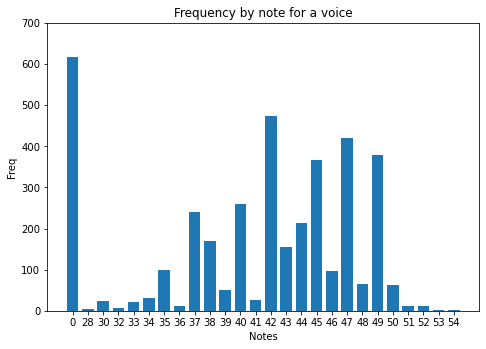

In [6]:
notes = []
freq = []
for x in set_X:
    notes.append(str(x))
    freq.append(X.count(x))
#     print(f"{x}:\t{X.count(x)}/{len(X)} ~\t{round((X.count(x)/len(X))*100,2)} %")

bar_chart(notes, freq, set_X)

In [ ]:
# Sliding window with one-step forecasting
X_t0 = np.array(X_vec[:-1])
y = np.array(X_vec[1:])
print(X_t0[0])
print(y[0])

In [ ]:
reg = LinearRegression().fit(X_t0, y)

In [ ]:
# Sanity check on last training instance
reg.predict([X_t0[-1]])

In [ ]:
# Possible (quick/easy) way to trace back to note:
# Get the max probability 
# Trace back the note via its index e.g.
yhat = reg.predict([X_t0[49]])
set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]

In [ ]:
# Cross validation for time series
tscv = TimeSeriesSplit()
print(tscv)

avg_acc = 0

for train_index, test_index in tscv.split(X_t0):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}] TEST: [{test_index[0]} ... {test_index[-1]}]")
    X_train, X_test = X_t0[train_index], X_t0[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    reg = LinearRegression().fit(X_train, y_train)
    y_pred_vec = reg.predict(X_test)
    
    # Convert one hot to note
    y_pred = [set_X[y.tolist().index(max(y.tolist()))] for y in y_pred_vec]
    y_test = [set_X[y.tolist().index(max(y.tolist()))] for y in y_test]
    
    print(accuracy_score(y_test, y_pred))
    avg_acc += accuracy_score(y_test, y_pred)
    
print(avg_acc/tscv.n_splits)